<a href="https://colab.research.google.com/github/pattom72/other/blob/master/XGB_adult.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import scipy.stats as sts
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

In [0]:
data= pd.read_csv("/content/adult.txt")
data.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,earnings
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [0]:
data.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
earnings          object
dtype: object

In [0]:
#sprawdzam czy w zbiorze występują braki danych
nulls_summary = pd.DataFrame(data.isnull().any(), columns=['Nulls'])
nulls_summary['Braki danych [ilość]'] = pd.DataFrame(data.isnull().sum())
nulls_summary['Braki danych [%]'] = round((data.isnull().mean()*100),2)
nulls_summary

,Nulls,Braki danych [ilość],Braki danych [%]
age,False,0,0.0
workclass,False,0,0.0
fnlwgt,False,0,0.0
education,False,0,0.0
education-num,False,0,0.0
marital-status,False,0,0.0
occupation,False,0,0.0
relationship,False,0,0.0
race,False,0,0.0
sex,False,0,0.0


In [0]:
data.skew()

age                0.558743
fnlwgt             1.446980
education-num     -0.311676
capital-gain      11.953848
capital-loss       4.594629
hours-per-week     0.227643
dtype: float64

In [0]:
#sprawdzam gdzie występują wartości odstające
Q_first = data.quantile(0.25)
Q_third = data.quantile(0.75)
iqr = Q_third-Q_first
low_boundary = (Q_first - 1.5 * iqr)
upp_boundary = (Q_third + 1.5 * iqr)
num_of_outliers_L = (data[iqr.index] < low_boundary).sum()
num_of_outliers_U = (data[iqr.index] > upp_boundary).sum()
wartosci_odstajace = pd.DataFrame({'niska_granica':low_boundary, 'wysoka_granica':upp_boundary,\
                         'wartosci_odstajace_L':num_of_outliers_L, 'wartosci_odstajace_U':num_of_outliers_U}) 
wartosci_odstajace

,niska_granica,wysoka_granica,wartosci_odstajace_L,wartosci_odstajace_U
age,-2.0,78.0,0,143
fnlwgt,-61009.0,415887.0,0,992
education-num,4.5,16.5,1198,0
capital-gain,0.0,0.0,0,2712
capital-loss,0.0,0.0,0,1519
hours-per-week,32.5,52.5,5516,3492


In [0]:
#sprawdzam liczności zmiennych kategorycznych 
for col in data.select_dtypes(['object', 'category']):
    print(data[col].value_counts())

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64
HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64
Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital-status, dtype: int64
Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         377

In [0]:
X, y = data.drop("earnings", axis=1), data.earnings
y

0        <=50K
1        <=50K
2        <=50K
3        <=50K
4        <=50K
         ...  
32556    <=50K
32557     >50K
32558    <=50K
32559    <=50K
32560     >50K
Name: earnings, Length: 32561, dtype: object

In [0]:
y.unique()

array(['<=50K', '>50K'], dtype=object)

In [0]:
pd.value_counts(y, normalize=True) 

<=50K    0.75919
>50K     0.24081
Name: earnings, dtype: float64

In [0]:
y = LabelEncoder().fit_transform(y)
y

array([0, 0, 0, ..., 0, 0, 1])

In [0]:
X_enc = pd.get_dummies(X)
X_enc

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_?,occupation_Adm-clerical,...,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_TrinadadTobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,40,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,257302,12,0,0,38,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
32557,40,154374,9,0,0,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
32558,58,151910,9,0,0,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
32559,22,201490,9,0,0,20,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [0]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_enc, y, test_size=0.2, random_state=123) 

In [0]:
X_train_val.head(3)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_?,occupation_Adm-clerical,...,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_TrinadadTobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
17064,19,219300,10,0,0,25,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
18434,58,116901,9,0,0,25,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3294,43,220589,9,0,0,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [0]:
X_test.head(3)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_?,occupation_Adm-clerical,...,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_TrinadadTobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
20713,55,199713,13,0,0,15,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
13495,65,115890,13,0,0,20,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
12367,29,145592,9,0,0,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
xgb_clas = xgb.XGBClassifier(max_depth=5, learning_rate=0.01)
scores = cross_val_score(xgb_clas, X_train_val, y_train_val, cv=10)
scores

array([0.8621881 , 0.84952015, 0.84261036, 0.86103647, 0.85566219,
       0.86295585, 0.84683301, 0.84644914, 0.85752688, 0.85176651])

In [0]:
xgb_clas_1 = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
scores_1 = cross_val_score(xgb_clas_1, X_train_val, y_train_val, cv=10)
scores_1

array([0.8403071 , 0.83685221, 0.82610365, 0.84568138, 0.84452975,
       0.84184261, 0.8353167 , 0.83147793, 0.83717358, 0.83448541])

In [0]:
#LGBM

lgbm_model = lgb.LGBMClassifier(max_depth=5)
scores_lgbm = cross_val_score(lgbm_model, X_train_val, y_train_val, cv=10)
scores_lgbm

array([0.8756238 , 0.87024952, 0.86794626, 0.88714012, 0.86564299,
       0.87715931, 0.87024952, 0.85758157, 0.88671275, 0.86059908])

In [0]:
print('xgb_clas',scores.mean(), scores.std())
print('xgb_clas_1',scores_1.mean(), scores_1.std())
print('lgbm_model',scores_lgbm.mean(), scores_lgbm.std())

xgb_clas 0.8536548673088206 0.00688431047045258
xgb_clas_1 0.8373770310551315 0.005687374289471008
lgbm_model 0.8718904918168121 0.009413624727352528


In [0]:
sts.kruskal(scores, scores_1,scores_lgbm)

KruskalResult(statistic=23.819492656875834, pvalue=6.7245447600677325e-06)

In [0]:
sts.friedmanchisquare(scores, scores_1,scores_lgbm)

FriedmanchisquareResult(statistic=20.0, pvalue=4.539992976248486e-05)

In [0]:
xgb_clas.fit(X_train_val,y_train_val)
preds = xgb_clas.predict(X_test)
preds

array([0, 0, 0, ..., 0, 1, 1])

In [0]:
y_test

array([0, 0, 0, ..., 0, 1, 1])

In [0]:
#from sklearn.metrics import mean_squared_error

#rmse = np.sqrt(mean_squared_error(y_test, preds))
#print("RMSE: %f" % (rmse))

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score


y_true = y_test
y_pred = preds

print('balanced accuracy score: ',balanced_accuracy_score(y_true, y_pred))
print('f1 score: ', f1_score(y_true, y_pred))

balanced accuracy score:  0.7442488196521675
f1 score:  0.6383945475198789


In [0]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
import plotly.figure_factory as ff

cm = confusion_matrix(y_test, y_pred)


def plot_confusion_matrix(cm):
    # klasyfikacja binarna
    cm = cm[::-1]
    cm = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_1', 'true_0'])

    fig = ff.create_annotated_heatmap(z=cm.values, x=list(cm.columns), y=list(cm.index), 
                                      colorscale='ice', showscale=True, reversescale=True)
    fig.update_layout(width=500, height=500, title='Confusion Matrix', font_size=16)
    fig.show()

plot_confusion_matrix(cm)

print()
print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
print()
print(classification_report(y_true, y_pred))


Accuracy: 0.8533701827115001

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      4927
           1       0.80      0.53      0.64      1586

    accuracy                           0.85      6513
   macro avg       0.83      0.74      0.77      6513
weighted avg       0.85      0.85      0.84      6513



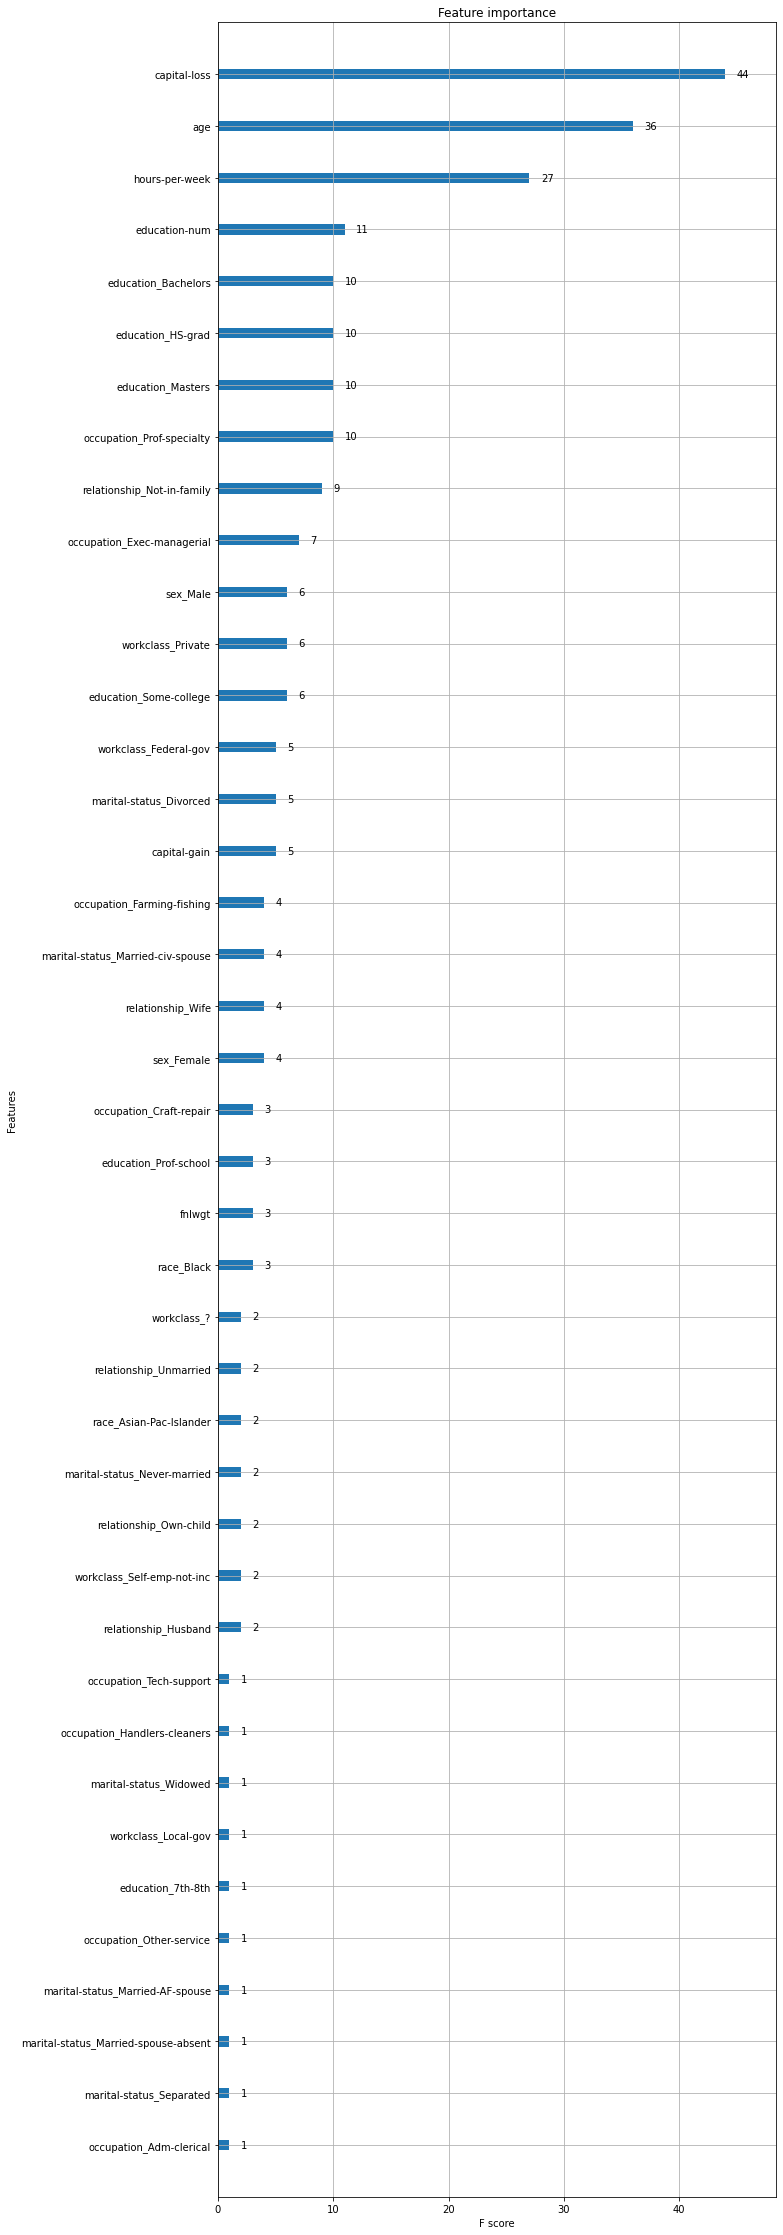

In [0]:
xgb.plot_importance(xgb_clas)
plt.rcParams['figure.figsize'] = [10, 30]
plt.show()

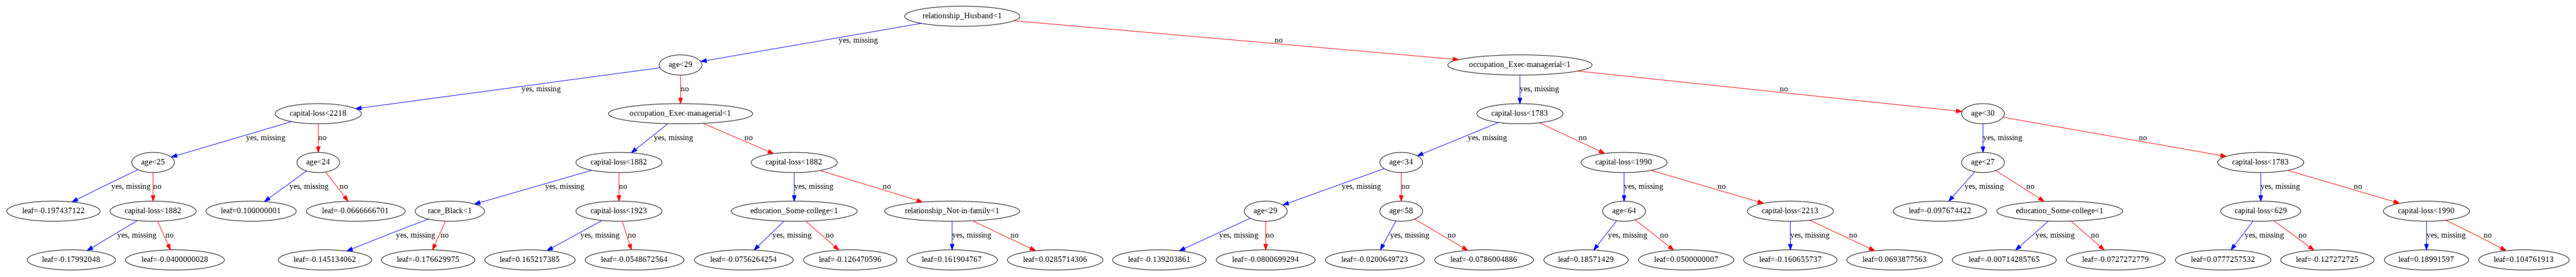

In [0]:
xgb.plot_tree(xgb_clas,num_trees=0)
plt.rcParams['figure.figsize'] = [90, 70]
plt.show()